## Library

In [138]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [139]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
initial_gdp = 21 * trillion                       # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    CREDIBLE_INTERVAL = 0.9                        # These are 90% CIs
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference. Take 10^13-17 from Carlsmith report and add 1 OOM due to algorithmic inefficiency.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # TODO: explain
    recursive_curve_steepness = 0
    recursive_curve_inflection = 0
    p_recursive_creates_tai_instantly = 0
    recursive_flops_halving_rate_ = None
    recursive_algo_doubling_rate_ = None
    recursive_spend_doubling_time = None
    recursive_gdp_growth_ = None
    recursive_initial_chance_of_nonscaling_issue = None
    recursive_final_chance_of_nonscaling_issue = None

elif USE_NUMBERS == 'Peter':
    CREDIBLE_INTERVAL = 0.9
    tai_flop_size = lognorm(28, 48.3)
    algo_doubling_rate = norm_lclip(1, 5)
    min_reduction = norm(1, 3)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(4, 8)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17.5)      # More increase in compute, plus possibilities that big companies have found some additional initial efficiency.
    flops_halving_rate = norm(2, 4)
    max_flops_per_dollar = norm(24, 26)            # Added uncertainty around fundamental limits
    initial_pay = norm(7, 8)                       # Minimum of $10M since that has already happened. Uncertain of how much we could be paying privately.
    gdp_growth = lognorm(1.02, 1.04)               # Added uncertainty around potential GDP slowdown
    max_gdp_frac = lognorm_lclip(0.0015, 0.025)    # Added uncertainty around how much of GDP we'd be willing to spend
    willingness_ramp = norm(0.7, 1)
    spend_doubling_time = lognorm_lclip(0.5, 2)    # Added uncertainty around how fast spending will accelerate
    initial_chance_of_nonscaling_issue = 0.75
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2040
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [140]:
initial_flops_p = get_percentiles([sample(tai_flop_size, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
initial_flops_p

{95: 28.331656772807957,
 90: 29.81010460433772,
 80: 31.834229834035376,
 70: 33.58783603720012,
 60: 35.15786616920819,
 50: 36.728755570302646,
 40: 38.13908600485944,
 30: 40.18716538460274,
 20: 42.30569452980414,
 10: 45.496988561280965,
 5: 48.864521421047925}

In [141]:
min_reduction_p = get_percentiles([sample(min_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
min_reduction_p

{95: 1.027054492795736,
 90: 1.205669835452666,
 80: 1.505390221776876,
 70: 1.7026453116737352,
 60: 1.8632637488171975,
 50: 2.0147746670508457,
 40: 2.156207631924668,
 30: 2.3121904254805874,
 20: 2.486950730335745,
 10: 2.7671559022787586,
 5: 2.9769746358178835}

In [142]:
max_reduction_p = get_percentiles([sample(max_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
max_reduction_p

{95: 4.060778355404052,
 90: 4.529499941746127,
 80: 5.011108533707705,
 70: 5.437329637418102,
 60: 5.755410431888899,
 50: 6.071991199178903,
 40: 6.339332521498487,
 30: 6.73998486665918,
 20: 7.119128247874958,
 10: 7.6273399030517846,
 5: 7.98447539969493}

In [143]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.0623426579010453,
 90: 1.5332776469948681,
 80: 2.013662491456849,
 70: 2.3614821014700413,
 60: 2.6456274778656166,
 50: 2.9662394154343312,
 40: 3.2980429170529475,
 30: 3.6584360678965897,
 20: 4.050767324358589,
 10: 4.563916878283617,
 5: 5.0357987767893215}

In [144]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_flops_per_dollar_p

{5: 16.99750253818533,
 10: 17.049431197844743,
 20: 17.10947503865832,
 30: 17.169730014984847,
 40: 17.210589726679444,
 50: 17.2548474918241,
 60: 17.292448743601902,
 70: 17.33139834225128,
 80: 17.38166335971357,
 90: 17.445364750458925,
 95: 17.506441161184014}

In [145]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 1.9782611479869063,
 90: 2.264394696956476,
 80: 2.5270782190249594,
 70: 2.7058795469220134,
 60: 2.8788323649993437,
 50: 3.0092908490200974,
 40: 3.1478280164593295,
 30: 3.302624593946121,
 20: 3.5114710689499966,
 10: 3.758821217121245,
 5: 3.983703321393134}

In [146]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_flops_per_dollar_p

{5: 24.067583902610522,
 10: 24.24689774926441,
 20: 24.494878632087605,
 30: 24.68496251620009,
 40: 24.854346517188496,
 50: 24.993955036730988,
 60: 25.144434477812815,
 70: 25.298790945969017,
 80: 25.491340104616754,
 90: 25.700186471420928,
 95: 25.91936914362619}

In [147]:
initial_pay_p = get_percentiles([sample(initial_pay, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_pay_p

{5: 6.971269883014234,
 10: 7.099830310141566,
 20: 7.251784538389333,
 30: 7.350228404983829,
 40: 7.427736271511057,
 50: 7.500276230065318,
 60: 7.578434565618821,
 70: 7.651921193267606,
 80: 7.754453615740322,
 90: 7.8764012968244055,
 95: 7.978526432983867}

In [148]:
gdp_growth_p = get_percentiles([sample(gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
gdp_growth_p

{5: 1.0200576716063285,
 10: 1.0223430944889396,
 20: 1.0250148909664394,
 30: 1.0269679782437928,
 40: 1.0286392853695092,
 50: 1.030132486526591,
 60: 1.0317340353225188,
 70: 1.0331569978421986,
 80: 1.0351852710015712,
 90: 1.0380679985569037,
 95: 1.0401789658627891}

In [149]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015,
 10: 0.0019626413311035545,
 20: 0.002883287329221665,
 30: 0.0038140799730196793,
 40: 0.004796945404428332,
 50: 0.006028830299214445,
 60: 0.007374193865577987,
 70: 0.009125341463450409,
 80: 0.01231649256246187,
 90: 0.016894969308088453,
 95: 0.023330671207992044}

In [150]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
willingness_ramp_p

{5: 0.7046099359470943,
 10: 0.7351837897623904,
 20: 0.7780641356147302,
 30: 0.8033262412642592,
 40: 0.8256804347340096,
 50: 0.8459707576402391,
 60: 0.8685916297003031,
 70: 0.8964040726066927,
 80: 0.9217590070976132,
 90: 0.9647607853454647,
 95: 0.9885777040122661}

In [151]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.516150557432778,
 90: 0.5767314167609998,
 80: 0.6945339598936854,
 70: 0.79247055038349,
 60: 0.8910352837053485,
 50: 0.9902594585188749,
 40: 1.0934322720050291,
 30: 1.238956550287503,
 20: 1.4552602376432935,
 10: 1.7401504563405366,
 5: 2.013129174974539}

In [152]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 0.9780193258680264,
 90: 1.4497994629513091,
 80: 2.1538522406812213,
 70: 2.8027144272475333,
 60: 3.5580877168232643,
 50: 4.472648626970052,
 40: 5.420886125359013,
 30: 6.966615668524348,
 20: 9.377111953481009,
 10: 13.897543583145424,
 5: 18.653129536304924}

In [153]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.30094996010589947, 10: 0.38698813295966955, 20: 0.4840852484825826, 30: 0.5724372036414418, 40: 0.662154036628062, 50: 0.7545725499200158, 60: 0.8730576766597533, 70: 1.0141783960244033, 80: 1.2497440987587878, 90: 1.6180668060737367, 95: 1.9014371184603809}


In [154]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.32161811434252763, 10: 0.3835800749859682, 20: 0.4872445906596745, 30: 0.5821420998868014, 40: 0.6713067076230614, 50: 0.7667974836275833, 60: 0.8707200359180387, 70: 1.0315249585145316, 80: 1.2467465179208326, 90: 1.5543083255970904, 95: 1.8420208292536113}


In [155]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.31021282479702156, 10: 0.3801312584730394, 20: 0.4693399834186187, 30: 0.5706162406990613, 40: 0.6798836575291096, 50: 0.7872714910055827, 60: 0.9005509758291146, 70: 1.0305780112781826, 80: 1.2410596553240234, 90: 1.6442466048728528, 95: 2.0494044701746588}


In [156]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.021470624171398, 10: 1.0303790359320282, 20: 1.0387031416905705, 30: 1.0461039203042803, 40: 1.052984531532185, 50: 1.0583597518362962, 60: 1.0646484958942888, 70: 1.0713803824123769, 80: 1.0792102620349129, 90: 1.0915258564453991, 95: 1.099929610603572}


## GDP Over Time

Text(0, 0.5, 'log GDP')

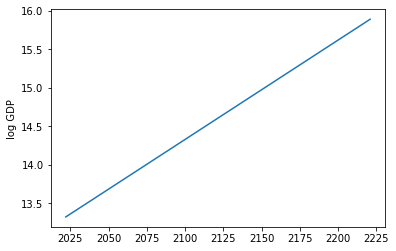

In [157]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [158]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.5 (10 trillion)
Year: 2033 - GDP log$ 13.5 (10 trillion)
Year: 2034 - GDP log$ 13.5 (10 trillion)
Year: 2035 - GDP log$ 13.5 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.6 (10 trillion)
Year: 2041 - GDP log$ 13.6 (10 trillion)
Year: 2042 - GDP log$ 13.6 (10 trillion)
Year: 2043 - GDP log$ 13.6 (10 trillion)
Year: 2044 - GDP log$ 13.6 (10 trillion)
Year: 2045 - GDP log$ 13.6 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

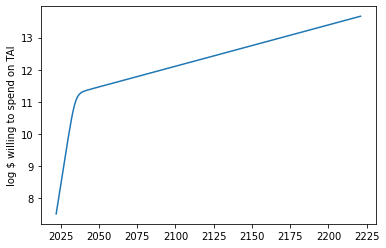

In [159]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [160]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.8 (10 million)
Year: 2024 - willingness log$ 8.1 (100 million)
Year: 2025 - willingness log$ 8.4 (100 million)
Year: 2026 - willingness log$ 8.7 (100 million)
Year: 2027 - willingness log$ 9.0 (one billion)
Year: 2028 - willingness log$ 9.3 (one billion)
Year: 2029 - willingness log$ 9.6 (one billion)
Year: 2030 - willingness log$ 9.9 (one billion)
Year: 2031 - willingness log$ 10.2 (10 billion)
Year: 2032 - willingness log$ 10.5 (10 billion)
Year: 2033 - willingness log$ 10.7 (10 billion)
Year: 2034 - willingness log$ 10.9 (10 billion)
Year: 2035 - willingness log$ 11.1 (100 billion)
Year: 2036 - willingness log$ 11.2 (100 billion)
Year: 2037 - willingness log$ 11.2 (100 billion)
Year: 2038 - willingness log$ 11.3 (100 billion)
Year: 2039 - willingness log$ 11.3 (100 billion)
Year: 2040 - willingness log$ 11.3 (100 billion)
Year: 2041 - willingness log$ 11.3 (100 billion)
Year: 2042 - willingness log$ 11.4 

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

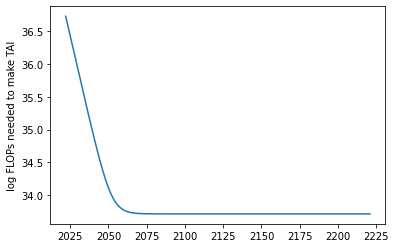

In [161]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [162]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 36.7 (one thousand decillion)
Year: 2023 - log FLOPs needed for TAI 36.6 (one thousand decillion)
Year: 2024 - log FLOPs needed for TAI 36.5 (one thousand decillion)
Year: 2025 - log FLOPs needed for TAI 36.4 (one thousand decillion)
Year: 2026 - log FLOPs needed for TAI 36.3 (one thousand decillion)
Year: 2027 - log FLOPs needed for TAI 36.2 (one thousand decillion)
Year: 2028 - log FLOPs needed for TAI 36.1 (one thousand decillion)
Year: 2029 - log FLOPs needed for TAI 36.0 (one thousand decillion)
Year: 2030 - log FLOPs needed for TAI 35.9 (100 decillion)
Year: 2031 - log FLOPs needed for TAI 35.8 (100 decillion)
Year: 2032 - log FLOPs needed for TAI 35.7 (100 decillion)
Year: 2033 - log FLOPs needed for TAI 35.6 (100 decillion)
Year: 2034 - log FLOPs needed for TAI 35.5 (100 decillion)
Year: 2035 - log FLOPs needed for TAI 35.4 (100 decillion)
Year: 2036 - log FLOPs needed for TAI 35.3 (100 decillion)
Year: 2037 - log FLOPs needed for TAI 35.2 

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

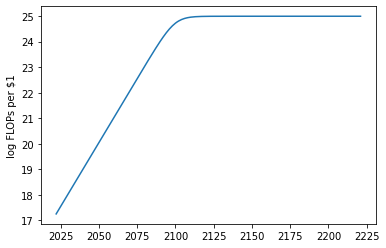

In [163]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [164]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

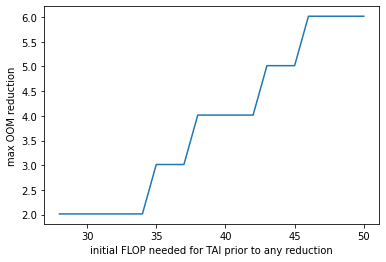

In [165]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [166]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                            max_reduction_p[GRAPH_P],
                                                                                            t)))
          

TAI log FLOP 28 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 29 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 30 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 31 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 32 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 33 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 34 -> 2.0147746670508457 OOM reductions possible
TAI log FLOP 35 -> 3.0147746670508457 OOM reductions possible
TAI log FLOP 36 -> 3.0147746670508457 OOM reductions possible
TAI log FLOP 37 -> 3.0147746670508457 OOM reductions possible
TAI log FLOP 38 -> 4.014774667050846 OOM reductions possible
TAI log FLOP 39 -> 4.014774667050846 OOM reductions possible
TAI log FLOP 40 -> 4.014774667050846 OOM reductions possible
TAI log FLOP 41 -> 4.014774667050846 OOM reductions possible
TAI log FLOP 42 -> 4.014774667050846 OOM reductions possible
TAI log FLOP 43 -> 5.014774667050846 OOM reductions possible
TAI log FLOP 4

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

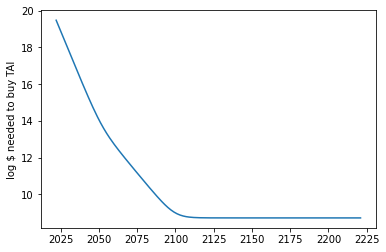

In [167]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [168]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 19.5 to buy TAI (10 quintillion)
Year: 2023 - log $ 19.3 to buy TAI (10 quintillion)
Year: 2024 - log $ 19.1 to buy TAI (10 quintillion)
Year: 2025 - log $ 18.9 to buy TAI (one quintillion)
Year: 2026 - log $ 18.7 to buy TAI (one quintillion)
Year: 2027 - log $ 18.5 to buy TAI (one quintillion)
Year: 2028 - log $ 18.3 to buy TAI (one quintillion)
Year: 2029 - log $ 18.1 to buy TAI (one quintillion)
Year: 2030 - log $ 17.9 to buy TAI (100 quadrillion)
Year: 2031 - log $ 17.7 to buy TAI (100 quadrillion)
Year: 2032 - log $ 17.5 to buy TAI (100 quadrillion)
Year: 2033 - log $ 17.3 to buy TAI (100 quadrillion)
Year: 2034 - log $ 17.1 to buy TAI (100 quadrillion)
Year: 2035 - log $ 16.9 to buy TAI (10 quadrillion)
Year: 2036 - log $ 16.7 to buy TAI (10 quadrillion)
Year: 2037 - log $ 16.5 to buy TAI (10 quadrillion)
Year: 2038 - log $ 16.3 to buy TAI (10 quadrillion)
Year: 2039 - log $ 16.1 to buy TAI (10 quadrillion)
Year: 2040 - log $ 15.9 to buy TAI (one quadrillion)
Y

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

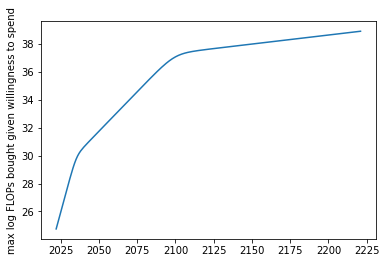

In [169]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [170]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.8 (one septillion)
Year: 2023 - max log FLOPs 25.2 (10 septillion)
Year: 2024 - max log FLOPs 25.6 (10 septillion)
Year: 2025 - max log FLOPs 26.0 (10 septillion)
Year: 2026 - max log FLOPs 26.4 (100 septillion)
Year: 2027 - max log FLOPs 26.8 (100 septillion)
Year: 2028 - max log FLOPs 27.2 (one octillion)
Year: 2029 - max log FLOPs 27.6 (one octillion)
Year: 2030 - max log FLOPs 28.0 (one octillion)
Year: 2031 - max log FLOPs 28.4 (10 octillion)
Year: 2032 - max log FLOPs 28.7 (10 octillion)
Year: 2033 - max log FLOPs 29.1 (100 octillion)
Year: 2034 - max log FLOPs 29.4 (100 octillion)
Year: 2035 - max log FLOPs 29.7 (100 octillion)
Year: 2036 - max log FLOPs 30.0 (100 octillion)
Year: 2037 - max log FLOPs 30.2 (one nonillion)
Year: 2038 - max log FLOPs 30.3 (one nonillion)
Year: 2039 - max log FLOPs 30.5 (one nonillion)
Year: 2040 - max log FLOPs 30.6 (one nonillion)
Year: 2041 - max log FLOPs 30.7 (one nonillion)
Year: 2042 - max log FLOPs 30.8 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

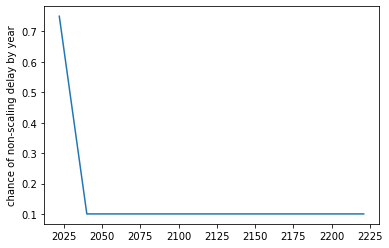

In [171]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')

In [172]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 75.0%
Year: 2023 - p(nonscaling delay) = 71.4%
Year: 2024 - p(nonscaling delay) = 67.8%
Year: 2025 - p(nonscaling delay) = 64.2%
Year: 2026 - p(nonscaling delay) = 60.6%
Year: 2027 - p(nonscaling delay) = 56.9%
Year: 2028 - p(nonscaling delay) = 53.3%
Year: 2029 - p(nonscaling delay) = 49.7%
Year: 2030 - p(nonscaling delay) = 46.1%
Year: 2031 - p(nonscaling delay) = 42.5%
Year: 2032 - p(nonscaling delay) = 38.9%
Year: 2033 - p(nonscaling delay) = 35.3%
Year: 2034 - p(nonscaling delay) = 31.7%
Year: 2035 - p(nonscaling delay) = 28.1%
Year: 2036 - p(nonscaling delay) = 24.4%
Year: 2037 - p(nonscaling delay) = 20.8%
Year: 2038 - p(nonscaling delay) = 17.2%
Year: 2039 - p(nonscaling delay) = 13.6%
Year: 2040 - p(nonscaling delay) = 10.0%
Year: 2041 - p(nonscaling delay) = 10.0%
Year: 2042 - p(nonscaling delay) = 10.0%
Year: 2043 - p(nonscaling delay) = 10.0%
Year: 2044 - p(nonscaling delay) = 10.0%
Year: 2045 - p(nonscaling delay) = 10.0%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

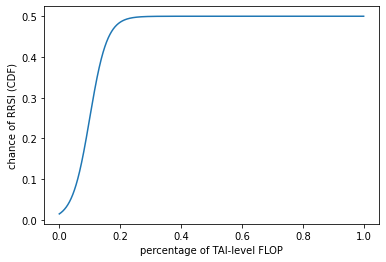

In [173]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [174]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=38.061159160973695, nonscaling_delay=6.980783531642025, algo_doubling_rate=3.0231235103408616, possible_algo_reduction=3.7724247661660173, initial_flops_per_dollar=2.2309599179927245e+17, flops_halving_rate=2.887397889986774, max_flops_per_dollar=1.3096288207109607e+26, initial_pay=51061869.56077617, gdp_growth=1.0317059595317648, max_gdp_frac=0.010200166673538315, willingness_ramp=0.8130057504287646, spend_doubling_time=1.5054477247695888
-
It takes 38.1 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 26.1 log FLOPs (100 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.5x per year to a max of 0.0102% of GDP. GDP grows at a rate of 1.032x per year.
If we are 81.0% of the way to paying f

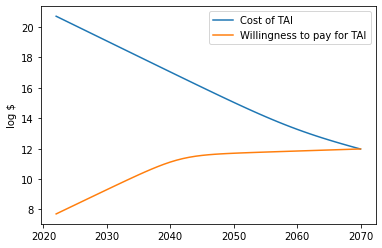

## RUN 2/10000 ##
Diagnostic: tai_flop_size=37.36031728305235, nonscaling_delay=0.98762882767414, algo_doubling_rate=2.8328747641031735, possible_algo_reduction=2.4960818805813316, initial_flops_per_dollar=9.90978390887275e+16, flops_halving_rate=2.195323447758683, max_flops_per_dollar=4.876740330811359e+25, initial_pay=34738919.04408947, gdp_growth=1.0276762475456949, max_gdp_frac=0.01080703444974308, willingness_ramp=0.8276537898757759, spend_doubling_time=1.2928028894592096
-
It takes 37.4 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (10 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.3x per year to a max of 0.0108% of GDP. GDP grows at a rate of 1.028x per year.
If we are 83.0% of the way to paying for TAI, we will r

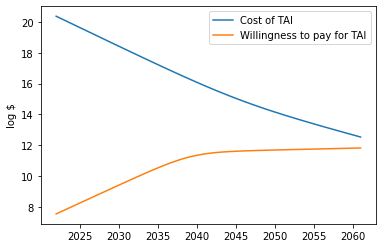

## RUN 3/10000 ##
Diagnostic: tai_flop_size=34.3557223790785, nonscaling_delay=2.642534373436558, algo_doubling_rate=3.7023751355194046, possible_algo_reduction=2.480906922512765, initial_flops_per_dollar=1.7443993836706813e+17, flops_halving_rate=3.1146292405179485, max_flops_per_dollar=3.112846448618866e+24, initial_pay=24805911.198041227, gdp_growth=1.0362779366553274, max_gdp_frac=0.002054970071144516, willingness_ramp=0.8000944286465895, spend_doubling_time=0.578319269154545
-
It takes 34.4 log FLOPs (10 decillion) for transformative capabilities.
Every 3.7 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.6x per year to a max of 0.0021% of GDP. GDP grows at a rate of 1.036x per year.
If we are 80.0% of the way to paying for TAI, we will ramp 

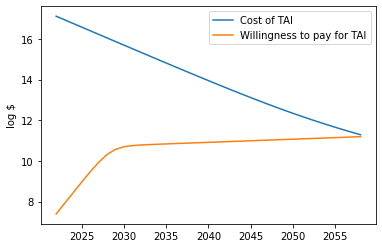

## RUN 4/10000 ##
Diagnostic: tai_flop_size=27.792511767823658, nonscaling_delay=8.088129435579065, algo_doubling_rate=5.143204728262397, possible_algo_reduction=1.4587898163773407, initial_flops_per_dollar=1.818637847456378e+17, flops_halving_rate=2.987227576046988, max_flops_per_dollar=3.050573262118735e+24, initial_pay=13823589.989437187, gdp_growth=1.0244575774399587, max_gdp_frac=0.0034855372897283263, willingness_ramp=0.9133833846934846, spend_doubling_time=3.4451571026014487
-
It takes 27.8 log FLOPs (one octillion) for transformative capabilities.
Every 5.1 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.1 log $ (10 million) and this increases by 3.4x per year to a max of 0.0035% of GDP. GDP grows at a rate of 1.024x per year.
If we are 91.0% of the way to paying for TAI, we will ra

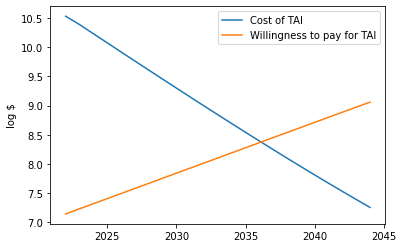

## RUN 5/10000 ##
Diagnostic: tai_flop_size=40.30613419807349, nonscaling_delay=4.550063523487003, algo_doubling_rate=2.683107753585412, possible_algo_reduction=4.314826914378473, initial_flops_per_dollar=2.6971434141184403e+17, flops_halving_rate=2.951410650670239, max_flops_per_dollar=3.0047338375976876e+24, initial_pay=34558115.78042717, gdp_growth=1.0224413974921882, max_gdp_frac=0.0064435099074443974, willingness_ramp=0.8571716371846385, spend_doubling_time=0.7626112798528025
-
It takes 40.3 log FLOPs (10 million decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.0064% of GDP. GDP grows at a rate of 1.022x per year.
If we are 86.0% of the way to paying for TAI, we w

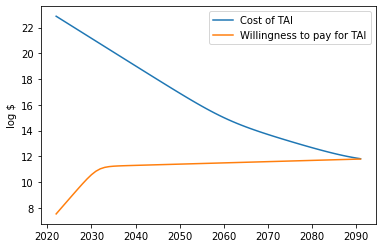

## RUN 6/10000 ##
Diagnostic: tai_flop_size=42.651641774768436, nonscaling_delay=9.05010791239779, algo_doubling_rate=1, possible_algo_reduction=4.923681934925144, initial_flops_per_dollar=1.3661099086945638e+17, flops_halving_rate=3.7813180952436696, max_flops_per_dollar=3.011547931977735e+24, initial_pay=29102335.80293762, gdp_growth=1.0264046280187273, max_gdp_frac=0.02976818357908782, willingness_ramp=0.6651334643723772, spend_doubling_time=0.6997892145930518
-
It takes 42.7 log FLOPs (one billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.8 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.7x per year to a max of 0.0298% of GDP. GDP grows at a rate of 1.026x per year.
If we are 67.0% of the way to paying for TAI, we will ramp to paying 

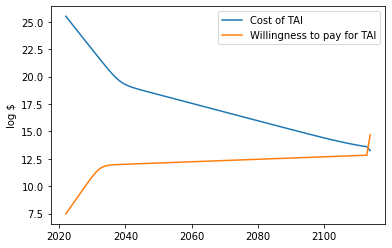

## RUN 7/10000 ##
Diagnostic: tai_flop_size=31.956377506109945, nonscaling_delay=7.8680769714027985, algo_doubling_rate=3.7876251763756152, possible_algo_reduction=1.850152735155146, initial_flops_per_dollar=2.3008353263117706e+17, flops_halving_rate=3.9155148603906955, max_flops_per_dollar=1.2498057381377376e+26, initial_pay=51978693.06296027, gdp_growth=1.0385520617909951, max_gdp_frac=0.003359628159564939, willingness_ramp=0.9059892176336467, spend_doubling_time=0.7708533163668326
-
It takes 32.0 log FLOPs (10 nonillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 26.1 log FLOPs (100 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.8x per year to a max of 0.0034% of GDP. GDP grows at a rate of 1.039x per year.
If we are 91.0% of the way to paying for TAI, we will r

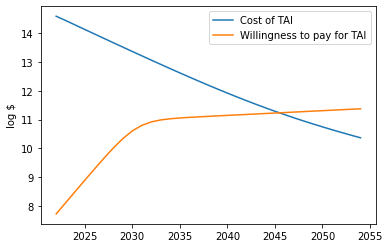

## RUN 8/10000 ##
Diagnostic: tai_flop_size=31.024905297669704, nonscaling_delay=1.7627728604247035, algo_doubling_rate=2.6682797794915327, possible_algo_reduction=2.086246791509041, initial_flops_per_dollar=1.8708679563218275e+17, flops_halving_rate=2.2042230838470527, max_flops_per_dollar=1.7363789504016582e+25, initial_pay=62252891.03790664, gdp_growth=1.0319453046869829, max_gdp_frac=0.006926837659383482, willingness_ramp=0.6781957130689638, spend_doubling_time=2.316770077849978
-
It takes 31.0 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 2.3x per year to a max of 0.0069% of GDP. GDP grows at a rate of 1.032x per year.
If we are 68.0% of the way to paying for TAI, we will ram

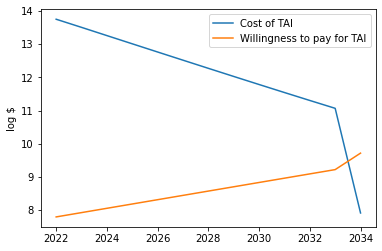

## RUN 9/10000 ##
Diagnostic: tai_flop_size=45.125476972428, nonscaling_delay=1.469740043204718, algo_doubling_rate=3.6876669908213158, possible_algo_reduction=5.029865471101244, initial_flops_per_dollar=1.3254563681057877e+17, flops_halving_rate=2.5930002191303205, max_flops_per_dollar=3.2387290026758513e+25, initial_pay=50063443.62381912, gdp_growth=1.0321641056175674, max_gdp_frac=0.0055870000629795235, willingness_ramp=0.8725637221496726, spend_doubling_time=0.7342190751726178
-
It takes 45.1 log FLOPs (one trillion decillion) for transformative capabilities.
Every 3.7 years algorithms get 2x better, with 5.0 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 25.5 log FLOPs (10 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.7x per year to a max of 0.0056% of GDP. GDP grows at a rate of 1.032x per year.
If we are 87.0% of the way to paying for TAI, we 

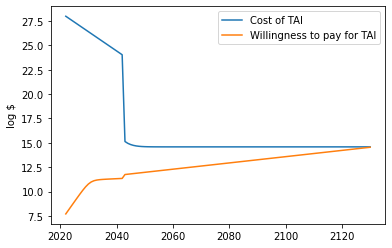

## RUN 10/10000 ##
Diagnostic: tai_flop_size=30.882662541735186, nonscaling_delay=2.1311590182586544, algo_doubling_rate=3.417955578554952, possible_algo_reduction=1.8616458208567646, initial_flops_per_dollar=1.258567824299621e+17, flops_halving_rate=2.853098122163204, max_flops_per_dollar=3.3131683555729484e+24, initial_pay=195297242.3886319, gdp_growth=1.04400642599647, max_gdp_frac=0.002182905869953487, willingness_ramp=0.7619804355459512, spend_doubling_time=1.5081762966917491
-
It takes 30.9 log FLOPs (one nonillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 8.3 log $ (100 million) and this increases by 1.5x per year to a max of 0.0022% of GDP. GDP grows at a rate of 1.044x per year.
If we are 76.0% of the way to paying for TAI, we will ra

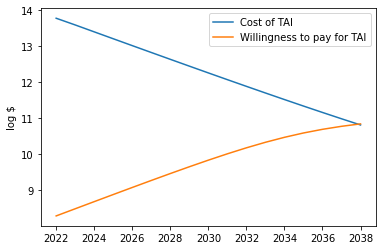

## RUN 11/10000 ##
Diagnostic: tai_flop_size=39.02848687808753, nonscaling_delay=3.252322165685926, algo_doubling_rate=1.4241578312869, possible_algo_reduction=3.815685129390194, initial_flops_per_dollar=1.5841125480086954e+17, flops_halving_rate=3.631355113259552, max_flops_per_dollar=3.553206119460641e+24, initial_pay=134515130.5840889, gdp_growth=1.0308784193427938, max_gdp_frac=0.013900242847562935, willingness_ramp=0.9531065805777016, spend_doubling_time=1.6842149092474987
-
It takes 39.0 log FLOPs (one million decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 8.1 log $ (100 million) and this increases by 1.7x per year to a max of 0.0139% of GDP. GDP grows at a rate of 1.031x per year.
If we are 95.0% of the way to paying for TAI, we wi

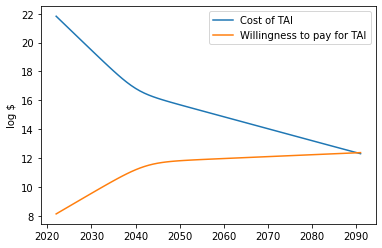

## RUN 12/10000 ##
Diagnostic: tai_flop_size=39.947940495208314, nonscaling_delay=3.7675397707782063, algo_doubling_rate=4.234105086148387, possible_algo_reduction=3.8792735603324915, initial_flops_per_dollar=1.1047972273222744e+17, flops_halving_rate=3.1671351148785547, max_flops_per_dollar=6.195874454798624e+24, initial_pay=59752313.89555485, gdp_growth=1.027859515712059, max_gdp_frac=0.019059670337486966, willingness_ramp=0.9009897112053638, spend_doubling_time=1.2471873092469186
-
It takes 39.9 log FLOPs (one million decillion) for transformative capabilities.
Every 4.2 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.2x per year to a max of 0.0191% of GDP. GDP grows at a rate of 1.028x per year.
If we are 90.0% of the way to paying for TAI, w

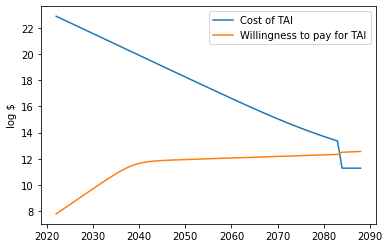

## RUN 13/10000 ##
Diagnostic: tai_flop_size=35.604465920265106, nonscaling_delay=14.503041555294898, algo_doubling_rate=1.950610078172512, possible_algo_reduction=3.2207214501905472, initial_flops_per_dollar=1.3084912087912163e+17, flops_halving_rate=2.9384985687440883, max_flops_per_dollar=2.2224657716261625e+24, initial_pay=45216000.33064897, gdp_growth=1.0266992910400812, max_gdp_frac=0.003761805953026913, willingness_ramp=0.8450116162010447, spend_doubling_time=0.5691119960438429
-
It takes 35.6 log FLOPs (100 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.6x per year to a max of 0.0038% of GDP. GDP grows at a rate of 1.027x per year.
If we are 85.0% of the way to paying for TAI, we will

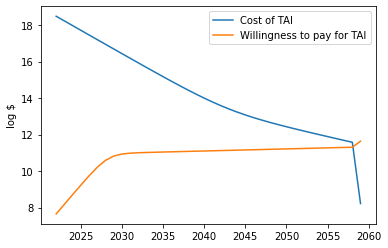

## RUN 14/10000 ##
Diagnostic: tai_flop_size=31.480345162115462, nonscaling_delay=3.3880043508345987, algo_doubling_rate=2.713110626345108, possible_algo_reduction=1.690423369831247, initial_flops_per_dollar=3.1931417739384275e+17, flops_halving_rate=4.8056527302264715, max_flops_per_dollar=5.798400924336522e+24, initial_pay=179314901.03705588, gdp_growth=1.035832422926882, max_gdp_frac=0.004956424209321203, willingness_ramp=0.7669492654256543, spend_doubling_time=1.4813781333023328
-
It takes 31.5 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 4.8 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 8.3 log $ (100 million) and this increases by 1.5x per year to a max of 0.005% of GDP. GDP grows at a rate of 1.036x per year.
If we are 77.0% of the way to paying for TAI, we will ra

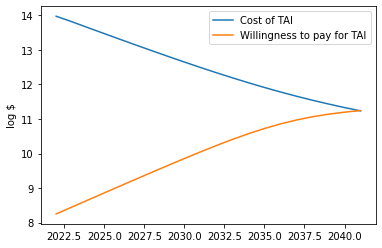

## RUN 15/10000 ##
Diagnostic: tai_flop_size=44.188686526588185, nonscaling_delay=2.8870689965569722, algo_doubling_rate=3.470522667429654, possible_algo_reduction=5.61723339115307, initial_flops_per_dollar=1.4854300512389936e+17, flops_halving_rate=2.6570589897421697, max_flops_per_dollar=1.3693445355103237e+25, initial_pay=16315692.80997556, gdp_growth=1.0330498625684497, max_gdp_frac=0.021446715316050382, willingness_ramp=1.0984145531296807, spend_doubling_time=1.2626929649967382
-
It takes 44.2 log FLOPs (100 billion decillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 5.6 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.3x per year to a max of 0.0214% of GDP. GDP grows at a rate of 1.033x per year.
If we are 110.0% of the way to paying for TAI, w

Year: 2049 - 32.3 max log FLOP (100 nonillion) available - TAI takes 41.8 log FLOP (100 million decillion) - log $ 21.6 to buy TAI (one sextillion) vs. willingness to pay log $ 12.0 (one trillion) - 20.2 log FLOPS per $ (100 quintillion)
--- no rapid recursive loop (p=0.0018320144378945126, r_=0.2783482209485739)
Year: 2050 - 32.4 max log FLOP (100 nonillion) available - TAI takes 41.8 log FLOP (100 million decillion) - log $ 21.4 to buy TAI (one sextillion) vs. willingness to pay log $ 12.0 (one trillion) - 20.3 log FLOPS per $ (100 quintillion)
--- no rapid recursive loop (p=0.0018320144483000757, r_=0.555930621034557)
Year: 2051 - 32.5 max log FLOP (100 nonillion) available - TAI takes 41.7 log FLOP (100 million decillion) - log $ 21.2 to buy TAI (one sextillion) vs. willingness to pay log $ 12.1 (one trillion) - 20.5 log FLOPS per $ (100 quintillion)
--- no rapid recursive loop (p=0.0018320144653328951, r_=0.268451529797886)
Year: 2052 - 32.6 max log FLOP (100 nonillion) available 

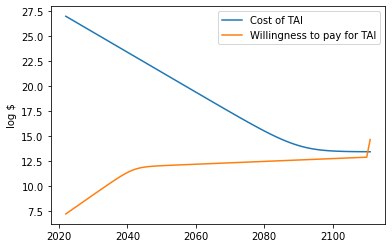

## RUN 16/10000 ##
Diagnostic: tai_flop_size=38.56416396213001, nonscaling_delay=5.787714117278021, algo_doubling_rate=3.2620383814837277, possible_algo_reduction=4.346577958574259, initial_flops_per_dollar=2.925064868453312e+17, flops_halving_rate=3.5041731786309116, max_flops_per_dollar=2.659097556906042e+24, initial_pay=43484143.78189106, gdp_growth=1.0339973779447718, max_gdp_frac=0.007436930833959941, willingness_ramp=0.8882225677102563, spend_doubling_time=0.6413238640370075
-
It takes 38.6 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 3.5 years they get 2x cheaper, to a maximum of 24.4 log FLOPs (one septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.6x per year to a max of 0.0074% of GDP. GDP grows at a rate of 1.034x per year.
If we are 89.0% of the way to paying for TAI, we

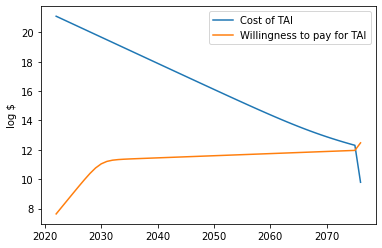

## RUN 17/10000 ##
Diagnostic: tai_flop_size=40.412470420526155, nonscaling_delay=7.650210850538853, algo_doubling_rate=2.824060601742832, possible_algo_reduction=3.9508769071546257, initial_flops_per_dollar=2.956247431657413e+17, flops_halving_rate=3.651192558945086, max_flops_per_dollar=5.781853187719307e+24, initial_pay=46846905.34446151, gdp_growth=1.0359400481744023, max_gdp_frac=0.005232600086569426, willingness_ramp=0.8680709537810624, spend_doubling_time=0.5
-
It takes 40.4 log FLOPs (10 million decillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 3.7 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.5x per year to a max of 0.0052% of GDP. GDP grows at a rate of 1.036x per year.
If we are 87.0% of the way to paying for TAI, we will ramp to pay

Year: 2102 - 36.3 max log FLOP (one thousand decillion) available - TAI takes 36.5 log FLOP (one thousand decillion) - log $ 12.5 to buy TAI (one trillion) vs. willingness to pay log $ 12.3 (one trillion) - 24.0 log FLOPS per $ (100 sextillion)
--- no rapid recursive loop (p=0.062499999238487015, r_=0.9571281306819428)
Year: 2103 - 36.3 max log FLOP (one thousand decillion) available - TAI takes 36.5 log FLOP (one thousand decillion) - log $ 12.4 to buy TAI (one trillion) vs. willingness to pay log $ 12.3 (one trillion) - 24.1 log FLOPS per $ (one septillion)
--- no rapid recursive loop (p=0.0624999999920615, r_=0.6639255616864865)
Year: 2104 - 36.4 max log FLOP (one thousand decillion) available - TAI takes 36.5 log FLOP (one thousand decillion) - log $ 12.3 to buy TAI (one trillion) vs. willingness to pay log $ 12.3 (one trillion) - 24.1 log FLOPS per $ (one septillion)
-- Nonscaling issue did not occur p_nonscaling_issue=0.1 r_=0.6355
--- /!\ TAI CREATED in 2104


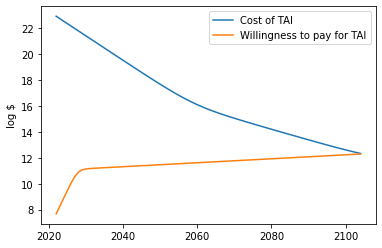

## RUN 18/10000 ##
Diagnostic: tai_flop_size=33.682037701347774, nonscaling_delay=9.143706007285765, algo_doubling_rate=2.4789361388687015, possible_algo_reduction=2.395357345685511, initial_flops_per_dollar=1.669666103067772e+17, flops_halving_rate=3.183062683685762, max_flops_per_dollar=4.487392328980883e+24, initial_pay=16756254.955316877, gdp_growth=1.0201535358835399, max_gdp_frac=0.01614802443013888, willingness_ramp=0.9321894713850905, spend_doubling_time=1.1057025402263039
-
It takes 33.7 log FLOPs (one decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.1x per year to a max of 0.0161% of GDP. GDP grows at a rate of 1.02x per year.
If we are 93.0% of the way to paying for TAI, we will ramp

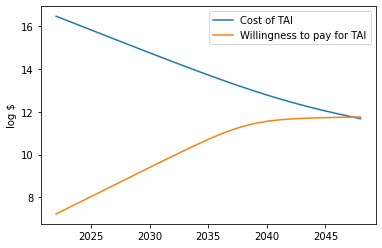

## RUN 19/10000 ##
Diagnostic: tai_flop_size=31.94619507743836, nonscaling_delay=6.953682297697647, algo_doubling_rate=2.6560708003448834, possible_algo_reduction=3.3373042363520877, initial_flops_per_dollar=2.6170295840102925e+17, flops_halving_rate=2.895916651761689, max_flops_per_dollar=1.765124670255966e+25, initial_pay=35370658.58636365, gdp_growth=1.028911481783795, max_gdp_frac=0.0015, willingness_ramp=0.7552659839181691, spend_doubling_time=1.7415380487094383
-
It takes 31.9 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.7x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.029x per year.
If we are 76.0% of the way to paying for TAI, we will ramp to paying for 

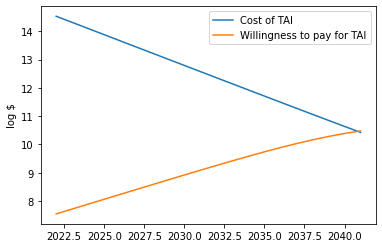

## RUN 20/10000 ##
Diagnostic: tai_flop_size=32.30235111281435, nonscaling_delay=4.408721977405642, algo_doubling_rate=2.624604662105617, possible_algo_reduction=1.7706182710512013, initial_flops_per_dollar=1.387227311854879e+17, flops_halving_rate=3.367171605382393, max_flops_per_dollar=1.1618695510193943e+25, initial_pay=43618739.46039563, gdp_growth=1.0333774964694775, max_gdp_frac=0.009026545238347389, willingness_ramp=0.9250837322766701, spend_doubling_time=2.076685791836326
-
It takes 32.3 log FLOPs (100 nonillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 2.1x per year to a max of 0.009% of GDP. GDP grows at a rate of 1.033x per year.
If we are 93.0% of the way to paying for TAI, we will ramp t

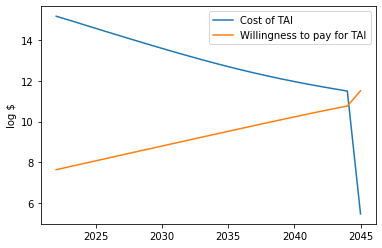

## RUN 21/10000 ##
Diagnostic: tai_flop_size=37.573230800628124, nonscaling_delay=1.9986964604413513, algo_doubling_rate=2.324644531675318, possible_algo_reduction=3.3265368798909334, initial_flops_per_dollar=2.2265346775077856e+17, flops_halving_rate=3.1198093656596457, max_flops_per_dollar=8.864857077658896e+23, initial_pay=15184205.21271055, gdp_growth=1.02887843534813, max_gdp_frac=0.005801377248938228, willingness_ramp=0.864489820517825, spend_doubling_time=0.9492061367204059
-
It takes 37.6 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 23.9 log FLOPs (100 sextillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.9x per year to a max of 0.0058% of GDP. GDP grows at a rate of 1.029x per year.
If we are 86.0% of the way to paying for TAI, we 

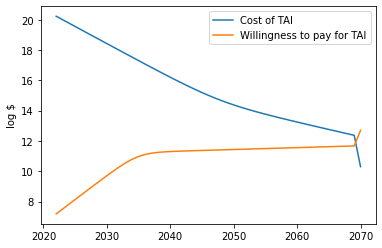

## RUN 22/10000 ##
Diagnostic: tai_flop_size=43.93612710817224, nonscaling_delay=9.604154819664101, algo_doubling_rate=3.2576376704889727, possible_algo_reduction=4.383216647587478, initial_flops_per_dollar=1.8258197135055834e+17, flops_halving_rate=2.7428420941742586, max_flops_per_dollar=2.197104412677302e+25, initial_pay=23723298.196187183, gdp_growth=1.0270621327542835, max_gdp_frac=0.004988452001697339, willingness_ramp=0.879329346462968, spend_doubling_time=0.7580730448703398
-
It takes 43.9 log FLOPs (10 billion decillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 25.3 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.8x per year to a max of 0.005% of GDP. GDP grows at a rate of 1.027x per year.
If we are 88.0% of the way to paying for TAI, we wi

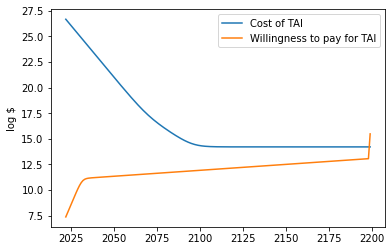

## RUN 23/10000 ##
Diagnostic: tai_flop_size=49.350399168592176, nonscaling_delay=0.9438027268077533, algo_doubling_rate=1, possible_algo_reduction=5.220730895705417, initial_flops_per_dollar=1.7158417536474736e+17, flops_halving_rate=3.970976962456368, max_flops_per_dollar=4.265369369370359e+25, initial_pay=35381710.25794185, gdp_growth=1.0335995542332912, max_gdp_frac=0.008859671357607636, willingness_ramp=0.7733736442312203, spend_doubling_time=0.6716943014015666
-
It takes 49.4 log FLOPs (10 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 4.0 years they get 2x cheaper, to a maximum of 25.6 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.7x per year to a max of 0.0089% of GDP. GDP grows at a rate of 1.034x per year.
If we are 77.0% of the way to paying for TAI, we will ramp to pa

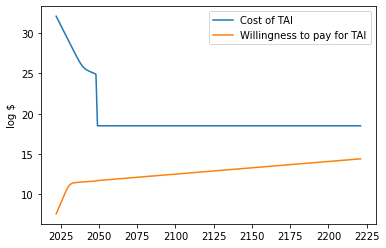

## RUN 24/10000 ##
Diagnostic: tai_flop_size=30.608887347720614, nonscaling_delay=3.298007411917291, algo_doubling_rate=3.524028494276417, possible_algo_reduction=2.133439583236876, initial_flops_per_dollar=1.7446607194551853e+17, flops_halving_rate=2.123492025323253, max_flops_per_dollar=2.6606325387381217e+25, initial_pay=36196662.99295332, gdp_growth=1.0258287182838997, max_gdp_frac=0.0025079169695932054, willingness_ramp=0.7728600027864804, spend_doubling_time=0.7504687702955
-
It takes 30.6 log FLOPs (one nonillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.1 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.8x per year to a max of 0.0025% of GDP. GDP grows at a rate of 1.026x per year.
If we are 77.0% of the way to paying for TAI, we will ramp 

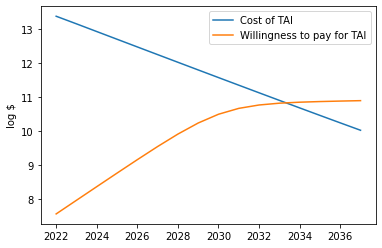

## RUN 25/10000 ##
Diagnostic: tai_flop_size=30.32686729927705, nonscaling_delay=4.301607982322019, algo_doubling_rate=3.383227888204324, possible_algo_reduction=1.2930994925194423, initial_flops_per_dollar=2.140780505263134e+17, flops_halving_rate=3.187777400760265, max_flops_per_dollar=3.2144246659261223e+26, initial_pay=35368967.17980548, gdp_growth=1.0296665594675245, max_gdp_frac=0.01081151490221665, willingness_ramp=0.9104862039860225, spend_doubling_time=0.768768531992968
-
It takes 30.3 log FLOPs (one nonillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 26.5 log FLOPs (100 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.0108% of GDP. GDP grows at a rate of 1.03x per year.
If we are 91.0% of the way to paying for TAI, we will ramp t

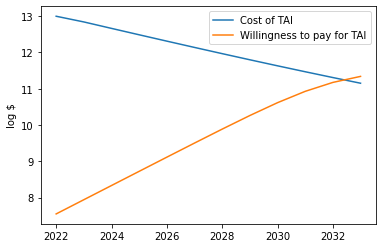

## RUN 26/10000 ##
Diagnostic: tai_flop_size=47.94574353039047, nonscaling_delay=8.629999538131843, algo_doubling_rate=3.6079116967876894, possible_algo_reduction=4.277736694880232, initial_flops_per_dollar=1.776304033999275e+17, flops_halving_rate=2.74514894406006, max_flops_per_dollar=2.4612963318424623e+25, initial_pay=42659446.92313991, gdp_growth=1.0280636321422525, max_gdp_frac=0.0038319380097251716, willingness_ramp=0.6587517852209134, spend_doubling_time=1.1388527582069041
-
It takes 47.9 log FLOPs (100 trillion decillion) for transformative capabilities.
Every 3.6 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.1x per year to a max of 0.0038% of GDP. GDP grows at a rate of 1.028x per year.
If we are 66.0% of the way to paying for TAI, we 

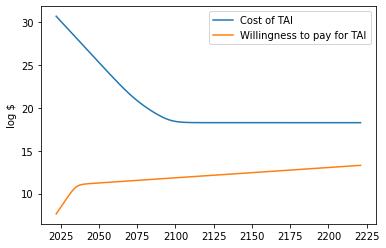

## RUN 27/10000 ##
Diagnostic: tai_flop_size=39.57586360727932, nonscaling_delay=7.539477316677261, algo_doubling_rate=3.9412720252596563, possible_algo_reduction=3.7907125759031244, initial_flops_per_dollar=2.2211281817027053e+17, flops_halving_rate=2.6266654739568764, max_flops_per_dollar=2.029255929038775e+25, initial_pay=77162941.64593482, gdp_growth=1.0321845390039712, max_gdp_frac=0.024219986687317025, willingness_ramp=0.8889784758527924, spend_doubling_time=1.4586490642821657
-
It takes 39.6 log FLOPs (one million decillion) for transformative capabilities.
Every 3.9 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 25.3 log FLOPs (10 septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.5x per year to a max of 0.0242% of GDP. GDP grows at a rate of 1.032x per year.
If we are 89.0% of the way to paying for TAI, we

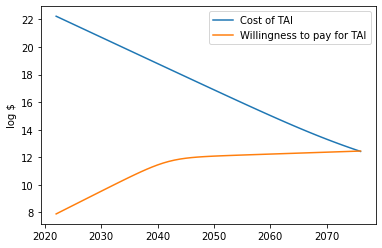

## RUN 28/10000 ##
Diagnostic: tai_flop_size=42.140218786827475, nonscaling_delay=1.3234010701275851, algo_doubling_rate=4.263456302772131, possible_algo_reduction=3.6898509261893118, initial_flops_per_dollar=1.3498279938236826e+17, flops_halving_rate=4.049814170099576, max_flops_per_dollar=4.5720374061866176e+24, initial_pay=21580853.731669154, gdp_growth=1.0359903351462836, max_gdp_frac=0.006627083172253362, willingness_ramp=0.9363353211563391, spend_doubling_time=1.328415079249918
-
It takes 42.1 log FLOPs (one billion decillion) for transformative capabilities.
Every 4.3 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 4.0 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.3x per year to a max of 0.0066% of GDP. GDP grows at a rate of 1.036x per year.
If we are 94.0% of the way to paying for TAI, 

Year: 2138 - 38.4 max log FLOP (100 thousand decillion) available - TAI takes 38.5 log FLOP (100 thousand decillion) - log $ 13.8 to buy TAI (10 trillion) vs. willingness to pay log $ 13.8 (10 trillion) - 24.7 log FLOPS per $ (one septillion)
-- Nonscaling delay occured p_nonscaling_issue=0.1 r_=0.0286
/!\ FLOPs for TAI sufficient but needs 1.3 more years to solve non-scaling issues
Year: 2139 - 38.5 max log FLOP (100 thousand decillion) available - TAI takes 38.5 log FLOP (100 thousand decillion) - log $ 13.8 to buy TAI (10 trillion) vs. willingness to pay log $ 13.8 (10 trillion) - 24.7 log FLOPS per $ (one septillion)
/!\ FLOPs for TAI sufficient but needs 0.3 more years to solve non-scaling issues
Year: 2140 - 38.5 max log FLOP (100 thousand decillion) available - TAI takes 38.5 log FLOP (100 thousand decillion) - log $ 13.8 to buy TAI (10 trillion) vs. willingness to pay log $ 13.8 (10 trillion) - 24.7 log FLOPS per $ (one septillion)
--- /!\ TAI CREATED in 2140


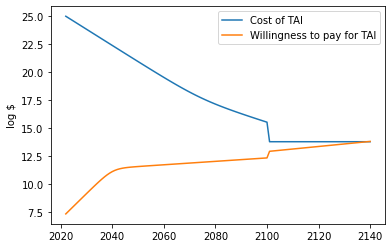

## RUN 29/10000 ##
Diagnostic: tai_flop_size=31.334137022561396, nonscaling_delay=5.014555847039029, algo_doubling_rate=4.955281491792474, possible_algo_reduction=2.4204545758499427, initial_flops_per_dollar=1.6539491964475203e+17, flops_halving_rate=3.591949026596006, max_flops_per_dollar=1.919381762161225e+25, initial_pay=27337107.521370333, gdp_growth=1.0271431895180212, max_gdp_frac=0.0052319860423604946, willingness_ramp=0.8480427710194326, spend_doubling_time=1.2377151929719623
-
It takes 31.3 log FLOPs (10 nonillion) for transformative capabilities.
Every 5.0 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 25.3 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.2x per year to a max of 0.0052% of GDP. GDP grows at a rate of 1.027x per year.
If we are 85.0% of the way to paying for TAI, we will ra

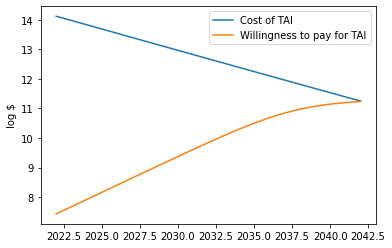

## RUN 30/10000 ##
Diagnostic: tai_flop_size=40.920426811663766, nonscaling_delay=7.703211899114309, algo_doubling_rate=2.67866363796965, possible_algo_reduction=4.9371478903361545, initial_flops_per_dollar=1.5402308042118413e+17, flops_halving_rate=2.0622408850517577, max_flops_per_dollar=2.1997630803232233e+24, initial_pay=49580594.9822758, gdp_growth=1.0298238133892843, max_gdp_frac=0.007439949225884655, willingness_ramp=0.8151345333411891, spend_doubling_time=1.1741829568452864
-
It takes 40.9 log FLOPs (10 million decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.1 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.2x per year to a max of 0.0074% of GDP. GDP grows at a rate of 1.03x per year.
If we are 82.0% of the way to paying for TAI, we w

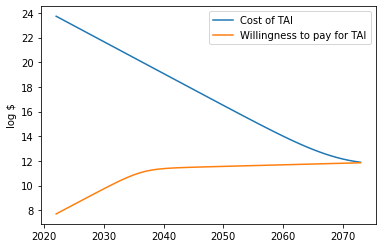

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [175]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size, credibility=CREDIBLE_INTERVAL)  # TODO: DRY out `, credibility=CREDIBLE_INTERVAL`
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction, credibility=CREDIBLE_INTERVAL),
                                                          sample(max_reduction, credibility=CREDIBLE_INTERVAL),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    flops_halving_rate_ = sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    initial_pay_ = 10 ** sample(initial_pay, credibility=CREDIBLE_INTERVAL)
    gdp_growth_ = sample(gdp_growth, credibility=CREDIBLE_INTERVAL)
    max_gdp_frac_ = sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL)
    willingness_ramp_ = sample(willingness_ramp, credibility=CREDIBLE_INTERVAL)
    spend_doubling_time_ = sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL)
    nonscaling_delay_ = sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        # TODO: add other recursive variables
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (p={}, r_={}) - set flops_having_rate={}, algo_doubling_rate={} ' +
                           'spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (p={}, r_={})'.format(p_recursive, r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [176]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 21 9:28PM CT):
#['5%: 2030',
# '10%: 2034',
# '20%: 2041',
# '30%: 2048',
# '40%: 2057',
# '50%: 2066',
# '60%: 2077',
# '70%: 2091',
# '80%: 2121',
# '90%: >2222',
# '95%: >2222']


['5%: 2030',
 '10%: 2034',
 '20%: 2041',
 '30%: 2048',
 '40%: 2057',
 '50%: 2066',
 '60%: 2077',
 '70%: 2091',
 '80%: 2121',
 '90%: >2222',
 '95%: >2222']

In [177]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 8 years from now',
 '10%: 12 years from now',
 '20%: 19 years from now',
 '30%: 26 years from now',
 '40%: 35 years from now',
 '50%: 44 years from now',
 '60%: 55 years from now',
 '70%: 69 years from now',
 '80%: 99 years from now',
 '90%: >200 years from now',
 '95%: >200 years from now']

In [178]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'0% chance of TAI by EOY 2023'

In [179]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [180]:
print_chance_tai_by_year(tai_years, 2025)

'1% chance of TAI by EOY 2025'

In [181]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'2% chance of TAI by EOY 2027'

In [182]:
print_chance_tai_by_year(tai_years, 2029)

'4% chance of TAI by EOY 2029'

In [183]:
print_chance_tai_by_year(tai_years, 2030)

'5% chance of TAI by EOY 2030'

In [184]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'8% chance of TAI by EOY 2032'

In [185]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'14% chance of TAI by EOY 2036'

In [186]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'15% chance of TAI by EOY 2037'

In [187]:
print_chance_tai_by_year(tai_years, 2039)

'18% chance of TAI by EOY 2039'

In [188]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'23% chance of TAI by EOY 2042'

In [189]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'29% chance of TAI by EOY 2047'

In [190]:
print_chance_tai_by_year(tai_years, 2049)

'32% chance of TAI by EOY 2049'

In [191]:
print_chance_tai_by_year(tai_years, 2059)

'43% chance of TAI by EOY 2059'

In [192]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'44% chance of TAI by EOY 2060'

In [193]:
print_chance_tai_by_year(tai_years, 2069)

'53% chance of TAI by EOY 2069'

In [194]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'54% chance of TAI by EOY 2070'

In [195]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'56% chance of TAI by EOY 2072'

In [196]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'62% chance of TAI by EOY 2078'

In [197]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'73% chance of TAI by EOY 2097'

In [198]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'75% chance of TAI by EOY 2100'

In [199]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'80% chance of TAI by EOY 2122'

In [200]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'88% chance of TAI by EOY 2222'

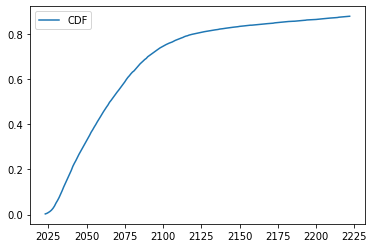

In [201]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

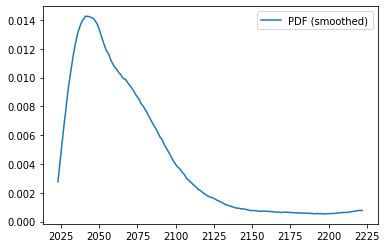

In [202]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [203]:
cdf[:len(bins)]

array([0.0028, 0.0052, 0.009 , 0.0135, 0.0193, 0.0272, 0.0375, 0.0509,
       0.0623, 0.0751, 0.0898, 0.1052, 0.1217, 0.1363, 0.1509, 0.1662,
       0.1811, 0.1958, 0.2134, 0.2269, 0.2392, 0.2529, 0.2665, 0.2788,
       0.291 , 0.3029, 0.3159, 0.3288, 0.3393, 0.3515, 0.365 , 0.3757,
       0.3877, 0.3986, 0.4107, 0.4213, 0.4326, 0.4442, 0.4552, 0.4658,
       0.4758, 0.4854, 0.4972, 0.5056, 0.5149, 0.524 , 0.5335, 0.5428,
       0.5512, 0.5604, 0.5698, 0.5784, 0.5878, 0.5983, 0.6075, 0.615 ,
       0.6236, 0.631 , 0.6362, 0.6442, 0.6522, 0.6595, 0.6676, 0.6737,
       0.6801, 0.6866, 0.6914, 0.699 , 0.704 , 0.7093, 0.7145, 0.7192,
       0.724 , 0.7284, 0.7332, 0.738 , 0.7418, 0.7453, 0.7491, 0.7529,
       0.7561, 0.7592, 0.7617, 0.7643, 0.7679, 0.7714, 0.7742, 0.7766,
       0.7796, 0.7821, 0.7845, 0.788 , 0.7904, 0.792 , 0.7948, 0.7967,
       0.7983, 0.7998, 0.8017, 0.8032, 0.8053, 0.8075, 0.8085, 0.8099,
       0.8111, 0.812 , 0.8136, 0.8151, 0.8159, 0.8173, 0.8179, 0.8189,
      

In [204]:
pdf[:len(bins)]

array([0.0028, 0.0024, 0.0038, 0.0045, 0.0058, 0.0079, 0.0103, 0.0134,
       0.0114, 0.0128, 0.0147, 0.0154, 0.0165, 0.0146, 0.0146, 0.0153,
       0.0149, 0.0147, 0.0176, 0.0135, 0.0123, 0.0137, 0.0136, 0.0123,
       0.0122, 0.0119, 0.013 , 0.0129, 0.0105, 0.0122, 0.0135, 0.0107,
       0.012 , 0.0109, 0.0121, 0.0106, 0.0113, 0.0116, 0.011 , 0.0106,
       0.01  , 0.0096, 0.0118, 0.0084, 0.0093, 0.0091, 0.0095, 0.0093,
       0.0084, 0.0092, 0.0094, 0.0086, 0.0094, 0.0105, 0.0092, 0.0075,
       0.0086, 0.0074, 0.0052, 0.008 , 0.008 , 0.0073, 0.0081, 0.0061,
       0.0064, 0.0065, 0.0048, 0.0076, 0.005 , 0.0053, 0.0052, 0.0047,
       0.0048, 0.0044, 0.0048, 0.0048, 0.0038, 0.0035, 0.0038, 0.0038,
       0.0032, 0.0031, 0.0025, 0.0026, 0.0036, 0.0035, 0.0028, 0.0024,
       0.003 , 0.0025, 0.0024, 0.0035, 0.0024, 0.0016, 0.0028, 0.0019,
       0.0016, 0.0015, 0.0019, 0.0015, 0.0021, 0.0022, 0.001 , 0.0014,
       0.0012, 0.0009, 0.0016, 0.0015, 0.0008, 0.0014, 0.0006, 0.001 ,
      

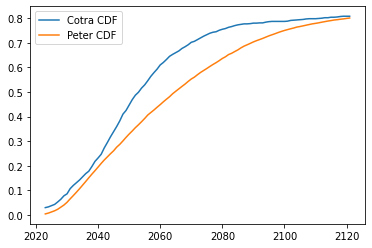

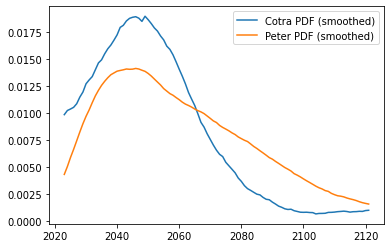

In [205]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0044, 0.0078, 0.0124, 0.0171, 0.0233, 0.0319, 0.0405, 0.0516,
       0.0655, 0.0787, 0.0923, 0.1064, 0.1211, 0.136 , 0.1512, 0.1661,
       0.1802, 0.1948, 0.2098, 0.2238, 0.2364, 0.2492, 0.2611, 0.276 ,
       0.2874, 0.3012, 0.3156, 0.3291, 0.3416, 0.355 , 0.3668, 0.3793,
       0.3924, 0.4065, 0.4168, 0.427 , 0.4381, 0.4487, 0.46  , 0.4706,
       0.4808, 0.4929, 0.503 , 0.5128, 0.5227, 0.5322, 0.543 , 0.5528,
       0.5604, 0.5703, 0.5796, 0.5876, 0.5955, 0.604 , 0.612 , 0.6194,
       0.6275, 0.6363, 0.6431, 0.6522, 0.6574, 0.6645, 0.6712, 0.6795,
       0.6865, 0.692 , 0.6977, 0.7036, 0.7087, 0.7132, 0.7179, 0.7231,
       0.7283, 0.7327, 0.7371, 0.7419, 0.7462, 0.7502, 0.7537, 0.7571,
       0.7602, 0.764 , 0.7662, 0.7689, 0.7717, 0.7744, 0.7771, 0.779 ,
       0.7812, 0.7838, 0.7861, 0.7885, 0.7904, 0.7927, 0.794 , 0.7958,
       0.7973, 0.7991, 0.8008, 0.803 , 0.8041, 0.8057, 0.807 , 0.808 ,
       0.8094, 0.8108, 0.812 , 0.8133, 0.8145, 0.8156, 0.8167, 0.8181,
       0.8194, 0.82  , 0.8206, 0.8213, 0.8222, 0.8227, 0.8233, 0.8239,
       0.8249, 0.8257, 0.8265, 0.8275, 0.8279, 0.8293, 0.8303, 0.831 ,
       0.832 , 0.8328, 0.8339, 0.8348, 0.8357, 0.8364, 0.8371, 0.838 ,
       0.8394, 0.84  , 0.8411, 0.8418, 0.8429, 0.8442, 0.8454, 0.8463,
       0.8475, 0.8479, 0.8487, 0.8489, 0.8495, 0.8498, 0.8504, 0.851 ,
       0.8518, 0.853 , 0.8539, 0.8542, 0.8546, 0.8553, 0.856 , 0.8571,
       0.8579, 0.8581, 0.8584, 0.8588, 0.8593, 0.8596, 0.8605, 0.8612,
       0.8619, 0.8627, 0.8631, 0.8639, 0.8644, 0.8651, 0.8656, 0.8658,
       0.8665, 0.8672, 0.8681, 0.869 , 0.8694, 0.87  , 0.8704, 0.8707,
       0.871 , 0.8713, 0.8717, 0.8721, 0.8727, 0.8733, 0.874 , 0.8746,
       0.8751, 0.8756, 0.876 , 0.8765, 0.8769, 0.8776, 0.878 ]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()